In [3]:
import numpy as np
import pandas as pd
import os

#PIC_DIR = f'drive/My Drive/celebdata/img_align_celeba/img_align_celeba/'

from tqdm import tqdm
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')
data_path_train = '/content/drive/My Drive/DeepLearning_2020/FP/Data/faces_train/'
data_path_test = '/content/drive/My Drive/DeepLearning_2020/FP/Data/faces_test/'
results_path = '/content/drive/My Drive/DeepLearning_2020/FP/Results/'

IMAGES_COUNT = 496

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images_train = []
for pic_file in tqdm(os.listdir(data_path_train)[:IMAGES_COUNT]):
    pic = Image.open(data_path_train + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images_train.append(np.uint8(pic))



images_test = []
for pic_file in tqdm(os.listdir(data_path_test)[:IMAGES_COUNT]):
    pic = Image.open(data_path_test + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images_test.append(np.uint8(pic))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


100%|██████████| 496/496 [03:51<00:00,  2.14it/s]


In [4]:

images_train = np.array(images_train) / 255
print("Train: "+ str(images_train.shape))
 
images_test = np.array(images_test) / 255
print("Test: "+ str(images_test.shape))

from matplotlib import pyplot as plt


Train: (496, 128, 128, 3)
Test: (496, 128, 128, 3)


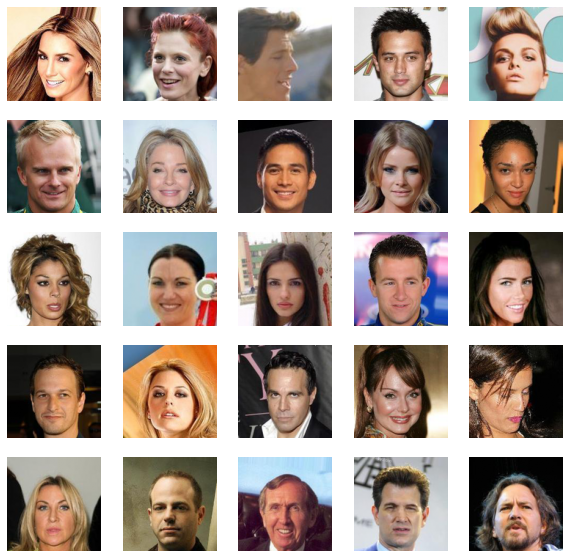

In [5]:
# train set
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i])
    plt.axis('off')
plt.savefig(results_path + 'imagen_train.png')
plt.show()


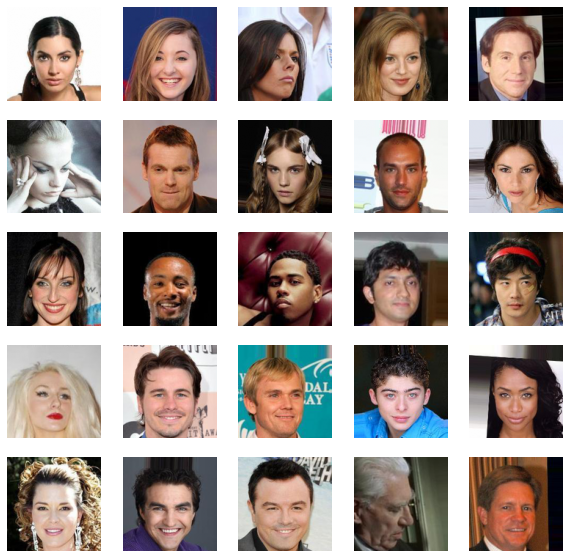

In [6]:
# test set
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_test[i])
    plt.axis('off')
plt.savefig(results_path + 'imagen_test.png')
plt.show()


In [7]:

from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3


Using TensorFlow backend.


In [8]:

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator



generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False


In [9]:

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')



In [12]:

import time
iters = 1000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images_train[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images_train.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('./drive/My Drive/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

# discriminant and adversary losses
#plt.figure(1, figsize=(12, 8))
#plt.subplot(121)
#plt.plot(d_losses)
#plt.xlabel('epochs')
#plt.ylabel('discriminant losses')
#plt.subplot(122)
#plt.plot(a_losses)
#plt.xlabel('epochs')
#plt.ylabel('adversary losses')
#plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave(results_path + 'train.gif', images_to_gif)
shutil.rmtree(RES_DIR)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/1000: d_loss: 0.7348,  a_loss: 1.0636.  (2.9 sec)
100/1000: d_loss: 0.6471,  a_loss: 0.9954.  (2.8 sec)
150/1000: d_loss: 0.6220,  a_loss: 0.8622.  (3.2 sec)
200/1000: d_loss: 0.6487,  a_loss: 1.0496.  (2.9 sec)
250/1000: d_loss: 0.6302,  a_loss: 0.9182.  (2.8 sec)
300/1000: d_loss: 0.6777,  a_loss: 0.9103.  (2.8 sec)
350/1000: d_loss: 0.6786,  a_loss: 0.8521.  (2.9 sec)
400/1000: d_loss: 0.6717,  a_loss: 0.9657.  (2.8 sec)
450/1000: d_loss: 0.7089,  a_loss: 1.0349.  (2.9 sec)
500/1000: d_loss: 0.6219,  a_loss: 1.0122.  (2.9 sec)
550/1000: d_loss: 0.5281,  a_loss: 1.2545.  (3.0 sec)
600/1000: d_loss: 0.5971,  a_loss: 0.8728.  (2.9 sec)
650/1000: d_loss: 0.6278,  a_loss: 0.9150.  (2.9 sec)
700/1000: d_loss: 0.6306,  a_loss: 0.8785.  (2.9 sec)
750/1000: d_loss: 0.6718,  a_loss: 0.9777.  (2.9 sec)
800/1000: d_loss: 0.6722,  a_loss: 0.9463.  (2.9 sec)
850/1000: d_loss: 0.7185,  a_loss: 1.1629.  (2.9 sec)
900/1000: d_loss: 0.6667,  a_loss: 0.8299.  (2.9 sec)
950/1000: d_loss: 0.6209,  a_

In [13]:

import time
iters = 50
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images_test[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images_test.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('./drive/My Drive/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave(results_path + 'test.gif' , images_to_gif)
shutil.rmtree(RES_DIR)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/50: d_loss: 0.6915,  a_loss: 0.7041.  (2.9 sec)
